# SkimLit
In this project, deep learning models are used to classify sentences which appear in a sequential order. 

**Dataset:** PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

Dataset: https://arxiv.org/abs/1710.06071

**Aim of the project:** Given the abstract of a RCT, what role does each sentence serve in the abstract.




## Contents:

1. Loading the data
2. Data preprocessing
3. Modelling experiments <br>
   3.1. Naive bayes with TF-IDF encoder <br>
   3.2. Conv1D with custom token embeddings <br>
   3.3. Conv1D with character embeddings <br>
   3.4. Feature extraction with pretrained token embeddings <br>
   3.5. Hybrid embedding layer <br>
   3.6. Transfer learning (tribrid model)
4. Compare all the model results
5. Saving the model
6. Visualising the results (on test data sample)
7. Predicting on unstructured PubMed RCT abstracts

## Import the nescessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import string
import tensorflow as tf
from tensorflow.keras import layers

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import warnings 
warnings.filterwarnings('ignore')

## Fetching the data 

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [3]:
# Checking what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20K dataset with numbers replaced by '@' sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [5]:
# Check all of the filenames in the target directory
import os

filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt']

## Data Preprocessing

In [6]:
# Create a function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text filename) and returns the lines of text as a list.
  
  Args:
    filename: a string containing the target filepath
  
  Returns:
    A list of strings with one string per line from the target filename.
  """
  with open(filename, "r") as f:
    return f.readlines()

In [15]:
# Reading in the training lines
train_lines = get_lines(filenames[0])
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [16]:
len(train_lines)

210040

In [17]:
def preprocess_text_with_line_numbers(filename):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line,
  extracting things like the target label, the text of the sentence, 
  how many sentences are in the current abstract and what sentence number 
  the target line is.
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in the target file
  for line in input_lines:
    if line.startswith("###"): # check to see if the line is an ID line
      abstract_id = line
      abstract_lines = "" # reset the abstract string if the line is an ID line
    
    elif line.isspace(): # check to see if the line is a new line
      abstract_line_split = abstract_lines.splitlines() # splits the abstract into seperate lines
      # print(abstract_line_split)

    # Iterate through each line in a single abstract and count them at the
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it 
        line_data["line_number"] = abstract_line_number# what number does the line appear in the abstract
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are there in the target abstract? (start from 0)
        abstract_samples.append(line_data)
    
    else: # if the above conditions aren't fulfilled, the line contains  labelled sentence
      abstract_lines += line
    
  return abstract_samples

In [19]:
# Get data from file and preprocess it 
%%time
train_samples = preprocess_text_with_line_numbers(filenames[0])
test_samples = preprocess_text_with_line_numbers(filenames[2])
validation_samples = preprocess_text_with_line_numbers(filenames[1])
print(f"Training sample length: {len(train_samples)}")
print(f"Validation sample length: {len(validation_samples)}")
print(f"Testing sample length: {len(test_samples)}")

Training sample length: 180040
Validation sample length: 30212
Testing sample length: 30135
CPU times: user 540 ms, sys: 99.1 ms, total: 639 ms
Wall time: 637 ms


In [21]:
# Check the first abstract of our training data
train_samples[:12]

[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [22]:
# Converting into a pandas dataframe
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(validation_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(12)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


### EDA

In [23]:
# Distribution of labels in training data
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

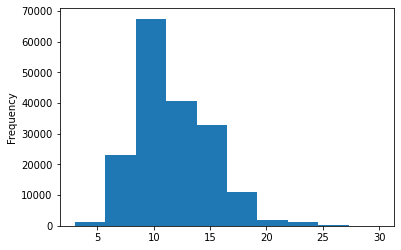

In [24]:
# Let's check the length of different lines
plt.hist(train_df["total_lines"]);
plt.ylabel("Frequency");

### Get a list of sentences

In [25]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].to_list()
validation_sentences = val_df["text"].to_list()
test_sentences = test_df["text"].to_list()
print(len(train_sentences), len(validation_sentences), len(test_sentences))

180040 30212 30135


In [26]:
# View the first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

### Making numeric labels (one hot encode & label encode)

In [27]:
# One hot encode labels
one_hot_encoder = OneHotEncoder(sparse=False) # we want a non-sparse matrix
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
validation_labels_one_hot = one_hot_encoder.fit_transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.fit_transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what one hot encoded labels look like
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [28]:
# Extract labels ("target" columns) and encode them into integers
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df["target"].to_numpy())

# Check what the training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [29]:
# Get class names and number of classes from LabelEncoder instance(map it back to text)
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Modelling Experiments

* Model 0 : Naive Bayes with TF-IDF Encoder
* Model 1 : Conv1D with custom token embeddings 
* Model 2 : Conv1D with character embeddings 
* Model 3 : Feature extraction with pretrained token embeddings 
* Model 4 : Hybrid embedding layer 
* Model 5: Transfer learning (tribrid model)


## Model 1: Naive Bayes with TF-IDF Encoder

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB()),
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences, 
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [31]:
# Evaluate baseline model on test dataset
model_0.score(X=test_sentences,
              y=test_labels_encoded)

0.716674962667994

In [32]:
# Make predicitions using the baseline model
baseline_preds = model_0.predict(test_sentences)
baseline_preds

array([2, 2, 2, ..., 4, 4, 4])

In [33]:
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
    y_true: true labels in the form of a 1D array
    y_preds: predicted labels in the form of a 1D array
  
  Returns a dictionary of accuracy, precision, recall, f1-score.
  """

  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using weighted average
  model_precision, model_recall, model_f1_score, _  = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1-score": model_f1_score}
  
  return model_results 

In [34]:
baseline_results = calculate_results(y_true=test_labels_encoded, 
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 71.6674962667994,
 'f1-score': 0.6925101703856846,
 'precision': 0.7124322482375202,
 'recall': 0.716674962667994}

## Model 2: Conv1D with custom token embeddings

### Preparing the data 

In [35]:
# Length of each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_lens = np.mean(sent_lens)
print(f"Avergae sentence length is {avg_sent_lens}")

Avergae sentence length is 26.338269273494777


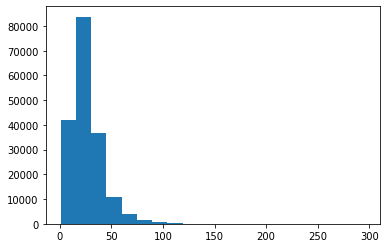

In [36]:
# Distribution 
plt.hist(sent_lens, bins=20);

In [37]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len  # 95% of examples have tokens of length 55 (at most)

55

In [38]:
# Maximum sequence length in the training set
max(sent_lens)

296

### Text vectorizer layer

In [39]:
max_tokens = 68000

# Create text vectorizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    pad_to_max_tokens=True,
                                    output_sequence_length=output_seq_len) 

# Adapt text vectorizer to the training sentences
text_vectorizer.adapt(train_sentences)

# Test out text vectorizer on random sentences
# target_sentence = random.choice(train_sentences)
# print(f"Text: \n{target_sentence}")
# print(f"\nLength of text: {len(target_sentence.split())}")
# print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

In [40]:
# Number of words in the training vocabulary 
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [41]:
# Configuration of the text vectorizer
text_vectorizer.get_config()

{'batch_input_shape': (None,),
 'dtype': 'string',
 'idf_weights': None,
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'ragged': False,
 'sparse': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary': None}

### Custom embedding layer

In [42]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),  
                               output_dim=128, 
                               mask_zero=False,  
                               name="token_embedding")

# Sample embedding
# print(f"Sentence before vectorization:\n {target_sentence}\n")
# vectorized_sentece = text_vectorizer([target_sentence])
# print(f"Vectorized text: (before embedding): \n{vectorized_sentece}\n")
# embedded_sentence = token_embed(vectorized_sentece)
# print(f"Sentence after embedding: \n{embedded_sentence}\n")
# print(f"Embedded sentence shape: {embedded_sentence.shape}")

### Creating TensorFlow datasets (more efficient)

In [43]:
# Turn our data into TensorFlow datasets

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((validation_sentences, validation_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [44]:
# The TensorSliceDataset's are turned into prefected datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Training dataset has not been shuffled as we want the model to learn order as well 
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

In [45]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1, ), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

# Summary of the model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 token_embedding (Embedding)  (None, 55, 128)          8299648   
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (G  (None, 64)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 5)                 325   

In [46]:
# Fitting the model 
history_1 = model_1.fit(train_dataset, 
                        steps_per_epoch=int(0.1*len(train_dataset)), # 10% of batches every epoch
                        epochs=10,
                        validation_data=valid_dataset,
                        validation_steps=int(0.1*len(valid_dataset)))                     

Epoch 1/10
562/562 [==============================] - 17s 14ms/step - loss: 0.9269 - accuracy: 0.6312 - val_loss: 0.6913 - val_accuracy: 0.7394
Epoch 2/10
562/562 [==============================] - 7s 13ms/step - loss: 0.6604 - accuracy: 0.7548 - val_loss: 0.6323 - val_accuracy: 0.7696
Epoch 3/10
562/562 [==============================] - 7s 13ms/step - loss: 0.6177 - accuracy: 0.7729 - val_loss: 0.5984 - val_accuracy: 0.7846
Epoch 4/10
562/562 [==============================] - 8s 13ms/step - loss: 0.5897 - accuracy: 0.7871 - val_loss: 0.5790 - val_accuracy: 0.7892
Epoch 5/10
562/562 [==============================] - 7s 13ms/step - loss: 0.5914 - accuracy: 0.7905 - val_loss: 0.5629 - val_accuracy: 0.7975
Epoch 6/10
562/562 [==============================] - 7s 13ms/step - loss: 0.5823 - accuracy: 0.7898 - val_loss: 0.5616 - val_accuracy: 0.8002
Epoch 7/10
562/562 [==============================] - 7s 13ms/step - loss: 0.5594 - accuracy: 0.8004 - val_loss: 0.5455 - val_accuracy: 0.807

In [47]:
# Evaluate on test dataset
model_1.evaluate(test_dataset)

942/942 [==============================] - 4s 4ms/step - loss: 0.5404 - accuracy: 0.8066


[0.5404382944107056, 0.8066368103027344]

In [48]:
# Make predictions (our model predicts prediction probabilities for each class)
model_1_pred_probs = model_1.predict(test_dataset)
model_1_pred_probs, model_1_pred_probs.shape

# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

# Calculate model_1 results
model_1_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.66368010618882,
 'f1-score': 0.8031249565615771,
 'precision': 0.8020268573426742,
 'recall': 0.8066368010618882}

## Model 3: Conv1D with character embeddings

### Creating a character-level tokenizer

In [49]:
# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

# Text splitting non-character lebel sequence into characters
random_train_sentence = random.choice(train_sentences)
split_chars(random_train_sentence)

'p a r t i c i p a n t s   w i l l   b e   a s s e s s e d   u s i n g   q u e s t i o n n a i r e s   a t   b a s e l i n e   ,   @ w e e k s   (   p o s t - i n t e r v e n t i o n   )   ,   a n d   @ w e e k s   (   f o l l o w - u p   )   .'

In [50]:
# Split sequenece-level data splits into character-level data splits
train_chars = [split_chars(sentences) for sentences in train_sentences]
val_chars = [split_chars(sentence) for sentence in validation_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
# train_chars[:5]

In [51]:
# Average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

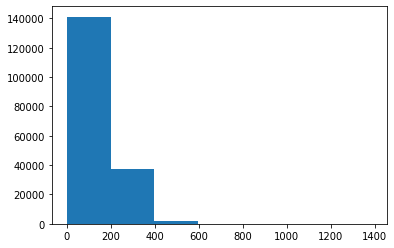

In [52]:
# Check the distributon of our sequences at a character-level
plt.hist(char_lens, bins=7);

In [53]:
# Character length that covers 95% of sequence
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [54]:
# Get all keyboard characters
alphabet = string.ascii_lowercase + string.digits + string.punctuation 

# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # add 2 for space and OOV token (OOV = out of order tokens)
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    name="char_vectorizer")

# Adapt character vectorizer to training character
char_vectorizer.adapt(train_chars)

# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

# Test our character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n {random_train_chars}")
print(f"\nLength of random_train_chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n {vectorized_chars}")
print(f"\nLength of vectorized chars:\n {len(vectorized_chars[0])}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']
Charified text:
 o u t c o m e s   w e r e   c o m p a r e d   b e t w e e n   s e x e s   w i t h i n   t r e a t m e n t   s t r a t a   .

Length of random_train_chars: 54

Vectorized chars:
 [[ 7 16  3 11  7 15  2  9 20  2  8  2 11  7 15 14  5  8  2 10 22  2  3 20
   2  2  6  9  2 24  2  9 20  4  3 13  4  6  3  8  2  5  3 15  2  6  3  9
   3  8  5  3  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

### Creating character-level embeddings

In [55]:
# Create a char embedding layer
char_embed = layers.Embedding(input_dim=len(char_vocab), 
                              output_dim=25, 
                              mask_zero=False,
                              name="char_embed")

# Test our character embedding layer
print(f"Charified text: \n {random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding) \n: {char_embed_example} \n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text: 
 o u t c o m e s   w e r e   c o m p a r e d   b e t w e e n   s e x e s   w i t h i n   t r e a t m e n t   s t r a t a   .

Embedded chars (after vectorization and embedding) 
: [[[-0.02156454 -0.02971679  0.02838251 ...  0.03508601  0.02482981
    0.02675383]
  [ 0.0278498   0.02156129  0.00865816 ... -0.00266842 -0.04520218
   -0.04231834]
  [-0.04977169 -0.01763422 -0.04055853 ... -0.02186637  0.00760897
   -0.01345543]
  ...
  [-0.03455371  0.03164018  0.01848502 ... -0.00826784 -0.03910179
   -0.02562314]
  [-0.03455371  0.03164018  0.01848502 ... -0.00826784 -0.03910179
   -0.02562314]
  [-0.03455371  0.03164018  0.01848502 ... -0.00826784 -0.03910179
   -0.02562314]]] 

Character embedding shape: (1, 290, 25)


### Creating character level datasets

In [56]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, validation_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [57]:
# Conv1D on chars 
inputs = layers.Input(shape=(1, ),
                      dtype=tf.string)
char_vectors = char_vectorizer(inputs)
char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(char_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_conv1d_char_embeddings")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Summary
model_2.summary()


Model: "model_2_conv1d_char_embeddings"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVector  (None, 290)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 

In [58]:
# Fit the model 
history_model_2 = model_2.fit(train_char_dataset,
                              epochs=10,
                              steps_per_epoch=int(0.1*len(train_char_dataset)),
                              validation_data=val_char_dataset,
                              validation_steps=int(0.1*len(val_char_dataset)))

Epoch 1/10
562/562 [==============================] - 6s 10ms/step - loss: 1.2688 - accuracy: 0.4900 - val_loss: 1.0417 - val_accuracy: 0.5878
Epoch 2/10
562/562 [==============================] - 5s 9ms/step - loss: 0.9958 - accuracy: 0.6023 - val_loss: 0.9202 - val_accuracy: 0.6336
Epoch 3/10
562/562 [==============================] - 5s 10ms/step - loss: 0.9116 - accuracy: 0.6454 - val_loss: 0.8458 - val_accuracy: 0.6752
Epoch 4/10
562/562 [==============================] - 5s 9ms/step - loss: 0.8607 - accuracy: 0.6639 - val_loss: 0.8170 - val_accuracy: 0.6862
Epoch 5/10
562/562 [==============================] - 5s 9ms/step - loss: 0.8470 - accuracy: 0.6735 - val_loss: 0.7940 - val_accuracy: 0.6958
Epoch 6/10
562/562 [==============================] - 5s 10ms/step - loss: 0.8288 - accuracy: 0.6779 - val_loss: 0.7687 - val_accuracy: 0.7098
Epoch 7/10
562/562 [==============================] - 5s 9ms/step - loss: 0.8140 - accuracy: 0.6839 - val_loss: 0.7568 - val_accuracy: 0.7141
Epo

In [59]:
# Make predictions 
model_2_pred_probs = model_2.predict(test_char_dataset)
model_2_pred_probs

# Convert prediction probabilities to class labels
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

# Calculate results for Conv1D model chars only
model_2_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 70.83789613406339,
 'f1-score': 0.7024440510850104,
 'precision': 0.7012305101730432,
 'recall': 0.7083789613406338}

## Model 4: Feature Extraction with pretrained token embeddings

In [60]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

# Test out the pretrained embedding on a random sentence
random_train_sentence = random.choice(train_sentences)
print(f"Random sentence:\n {random_train_sentence}")
use_embedded_sentence = tf_hub_embedding_layer([random_train_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n") 
print(f"Length of sentence embedding: {len(use_embedded_sentence[0])}")

Random sentence:
 neither passive recovery nor running at ~ @ % of vo@peak between @ heats changed performance significantly .
Sentence after embedding:
[-0.04396169 -0.01435326 -0.01762747 -0.04491922 -0.02494883  0.05895257
  0.01702224 -0.01929711  0.05414889  0.07134083 -0.02278336 -0.04645795
 -0.03265717 -0.02391117 -0.00881385  0.04278456  0.02114337 -0.06583799
 -0.0090386   0.01509295  0.05862322  0.03483447 -0.02182192 -0.04012351
  0.00965327  0.06971093  0.07131387  0.04854383 -0.07365382  0.03571198]

Length of sentence embedding: 512


In [61]:
# Model construction

# Define feature extraction model using TF Hub layer
inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) 
x = layers.Dense(128, activation="relu")(pretrained_embedding)
outputs = layers.Dense(num_classes, activation="softmax")(x) 
model_3 = tf.keras.Model(inputs=inputs, 
                         outputs=outputs,
                         name="model_3_USE_feature_extractor")
# Compile the model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Summary of the model 
model_3.summary()

Model: "model_3_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [62]:
# Fit model to the data
history_model_3 = model_3.fit(train_dataset,
                              epochs=10,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)))

Epoch 1/10
562/562 [==============================] - 14s 19ms/step - loss: 0.9178 - accuracy: 0.6511 - val_loss: 0.7974 - val_accuracy: 0.6902
Epoch 2/10
562/562 [==============================] - 11s 19ms/step - loss: 0.7696 - accuracy: 0.7021 - val_loss: 0.7574 - val_accuracy: 0.7015
Epoch 3/10
562/562 [==============================] - 11s 19ms/step - loss: 0.7535 - accuracy: 0.7124 - val_loss: 0.7416 - val_accuracy: 0.7121
Epoch 4/10
562/562 [==============================] - 11s 19ms/step - loss: 0.7196 - accuracy: 0.7234 - val_loss: 0.7136 - val_accuracy: 0.7287
Epoch 5/10
562/562 [==============================] - 10s 19ms/step - loss: 0.7280 - accuracy: 0.7205 - val_loss: 0.6925 - val_accuracy: 0.7337
Epoch 6/10
562/562 [==============================] - 11s 19ms/step - loss: 0.7180 - accuracy: 0.7259 - val_loss: 0.6843 - val_accuracy: 0.7320
Epoch 7/10
562/562 [==============================] - 11s 19ms/step - loss: 0.6856 - accuracy: 0.7379 - val_loss: 0.6663 - val_accuracy:

In [63]:
# Evaluate on the whole test dataset
model_3.evaluate(test_dataset)

942/942 [==============================] - 15s 16ms/step - loss: 0.6715 - accuracy: 0.7438


[0.6714958548545837, 0.7438194751739502]

In [64]:
# Make predictions with feature extraction model
model_3_pred_probs = model_3.predict(test_dataset)
model_3_pred_probs

# Convert the prediction probabilites found with feature extraction model to labels
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

# Calculate result from TF Hub pretrained embeddings 
model_3_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 74.38194790111167,
 'f1-score': 0.7388490158220625,
 'precision': 0.7382607470265952,
 'recall': 0.7438194790111167}

## Model 5: Creating a hybrid embedding layer (pretrained token embeddings + character embeddings)

### Combining token and character datasets 

In [65]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))  
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) 
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) 
# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For the validation data
valid_char_token_data = tf.data.Dataset.from_tensor_slices((validation_sentences, val_chars))  
valid_char_token_labels = tf.data.Dataset.from_tensor_slices(validation_labels_one_hot) 
valid_char_token_dataset = tf.data.Dataset.zip((valid_char_token_data, valid_char_token_labels)) 
valid_char_token_dataset = valid_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For the test data
test_char_token_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_chars))  
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot) 
test_char_token_dataset = tf.data.Dataset.zip((test_char_token_data, test_char_token_labels)) 
test_char_token_dataset = test_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [66]:
# Model Construction

# 1. Setup token inputs/model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) 
char_model = tf.keras.Model(inputs=char_inputs, outputs=char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embeddings)
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, 
                                                                  char_model.output])

# 4. Create output layers 
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_token_and_char_embeddings")

# Summary
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_input[0][0]']             
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   [

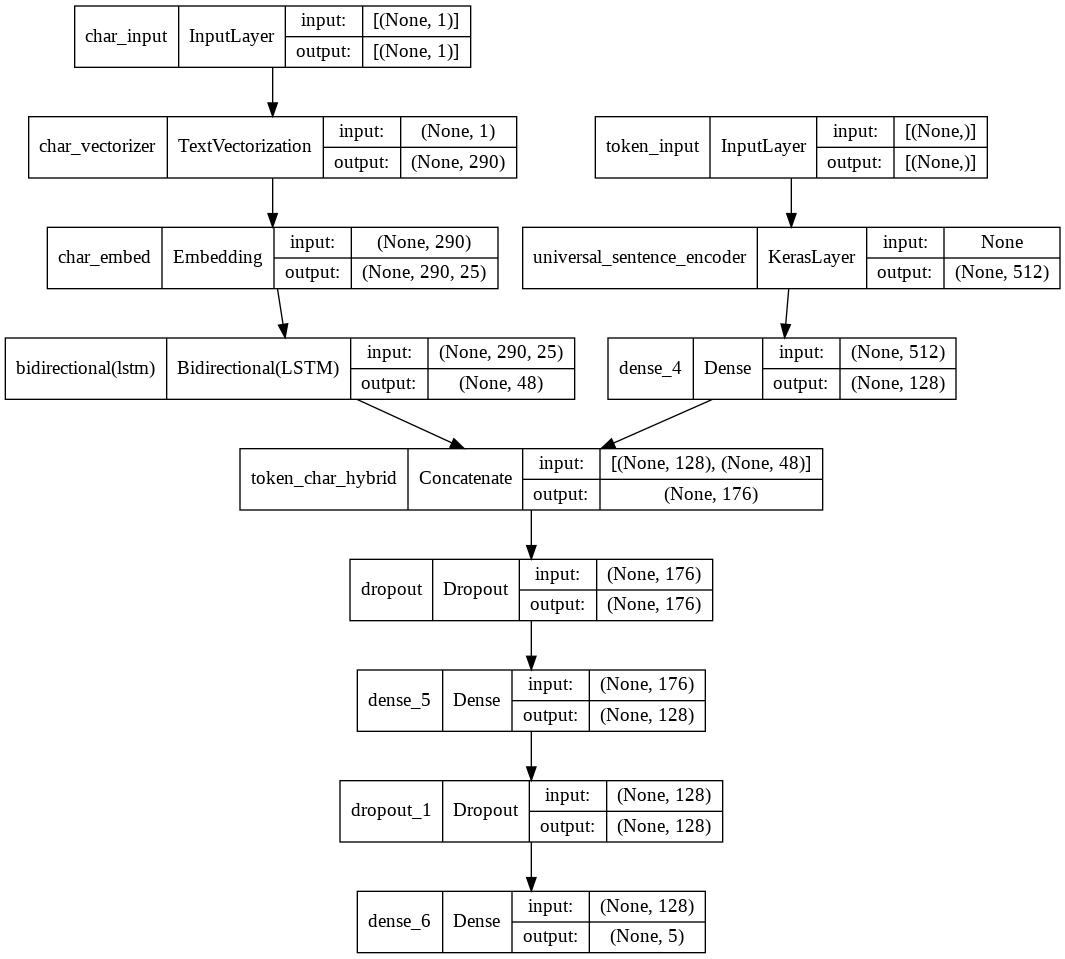

In [67]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [68]:
# Compile token char model
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), 
                metrics=["accuracy"])

In [69]:
# Fit the model
history_model_4 = model_4.fit(train_char_token_dataset,
                              epochs=10,
                              steps_per_epoch=int(0.1*len(train_char_token_dataset)),
                              validation_data=valid_char_token_dataset,
                              validation_steps=int(0.1*len(valid_char_token_dataset)))

Epoch 1/10
562/562 [==============================] - 71s 117ms/step - loss: 0.9791 - accuracy: 0.6069 - val_loss: 0.7833 - val_accuracy: 0.6948
Epoch 2/10
562/562 [==============================] - 64s 115ms/step - loss: 0.8036 - accuracy: 0.6891 - val_loss: 0.7208 - val_accuracy: 0.7287
Epoch 3/10
562/562 [==============================] - 64s 115ms/step - loss: 0.7770 - accuracy: 0.7027 - val_loss: 0.6917 - val_accuracy: 0.7350
Epoch 4/10
562/562 [==============================] - 64s 114ms/step - loss: 0.7432 - accuracy: 0.7195 - val_loss: 0.6693 - val_accuracy: 0.7457
Epoch 5/10
562/562 [==============================] - 64s 115ms/step - loss: 0.7450 - accuracy: 0.7166 - val_loss: 0.6583 - val_accuracy: 0.7563
Epoch 6/10
562/562 [==============================] - 64s 115ms/step - loss: 0.7437 - accuracy: 0.7169 - val_loss: 0.6507 - val_accuracy: 0.7576
Epoch 7/10
562/562 [==============================] - 64s 114ms/step - loss: 0.7116 - accuracy: 0.7313 - val_loss: 0.6363 - val_ac

In [70]:
# Evaluate on the whole test dataset
model_4.evaluate(test_char_token_dataset)

942/942 [==============================] - 48s 51ms/step - loss: 0.6439 - accuracy: 0.7551


[0.643907904624939, 0.755068838596344]

In [71]:
# Make predictions
model_4_preds_probs = model_4.predict(test_char_token_dataset)
model_4_preds_probs

# Convert prediction probabilities to class labels
model_4_preds = tf.argmax(model_4_preds_probs, axis=1)
model_4_preds

# Results for token-char-hybrid model
model_4_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 75.5068856811017,
 'f1-score': 0.7509276290932916,
 'precision': 0.7528350030491194,
 'recall': 0.7550688568110171}

## Model 6: Transfer learning with pretrained token embeddings, character embeddings and positional embeddings

### Creating positional embeddings

In [72]:
# Number of different line numbers present
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

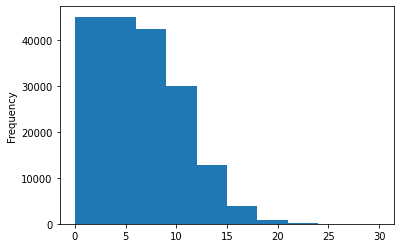

In [73]:
# Distribution of "line_number" column
train_df.line_number.plot.hist();

In [74]:
# One-hot-encoding tensors of the "line_number" column
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

train_line_numbers_one_hot[:10], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [75]:
# Different number of line present
train_df["total_lines"].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

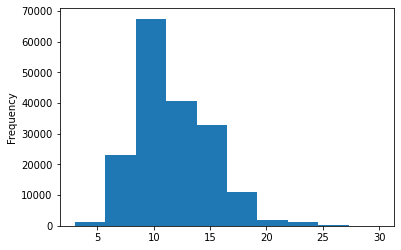

In [76]:
# Distribution of total lines
train_df.total_lines.plot.hist();

In [77]:
# Coverage of a "total_lines" value of 20
np.percentile(train_df.total_lines, 98)

20.0

In [78]:
# One-hot-encoding tensors of "total_lines" feature
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

### Creating datasets

In [79]:
# Create training, validation and test datasets (with all four kinds of input data)
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# For the validation dataset
val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                              val_total_lines_one_hot,
                                                              validation_sentences,
                                                              val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(validation_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


# For the test dataset
test_char_token_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                               test_total_lines_one_hot,
                                                               test_sentences,
                                                               test_chars))
test_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_pos_dataset = tf.data.Dataset.zip((test_char_token_pos_data, test_char_token_pos_labels))
test_char_token_pos_dataset = test_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
#test_char_token_pos_dataset

### Building a tribrid embedding model

In [80]:
# 1. Token inputs
token_inputs = layers.Input(shape=[], dtype="string", name="token_inputs")
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu") (token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_outputs)

# 2. Char inputs
char_inputs = layers.Input(shape=(1, ), dtype="string", name="char_inputs")
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                            outputs=char_bi_lstm)

# 3. Line numbers model
line_numbers_input = layers.Input(shape=(15, ), dtype=tf.float32, name="line_numbers") 
line_numbers_output = layers.Dense(32, activation="relu")(line_numbers_input)
line_numbers_model = tf.keras.Model(inputs=line_numbers_input,
                                    outputs=line_numbers_output)

# 4. Total lines model
total_lines_input = layers.Input(shape=(20, ), dtype=tf.float32, name="total_lines")
total_lines_output = layers.Dense(32, activation="relu")(total_lines_input)
total_lines_model = tf.keras.Model(inputs=total_lines_input,
                                   outputs=total_lines_output)

# 5. Combine token and char embeddings into a hybrid embedding
combined_embeddings = layers.Concatenate(name="char_token_hybrid_embedding")([token_model.output, char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings
tribrid_embeddings = layers.Concatenate(name="char_token_positional_embedding")([line_numbers_model.output,
                                                                                 total_lines_model.output,
                                                                                 z])


# 7. Create output layer
output_layer = layers.Dense(5, activation="softmax", name="output_layer")(tribrid_embeddings)

# 8. Put together model with all kinds of inputs
model_5 = tf.keras.Model(inputs=[line_numbers_model.input,
                                 total_lines_model.input, 
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="model_5_tribrid_embedding_model")

# Get a summary of tribrid model
model_5.summary()

Model: "model_5_tribrid_embedding_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_inputs (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 290)         0           ['char_inputs[0][0]']            
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['t

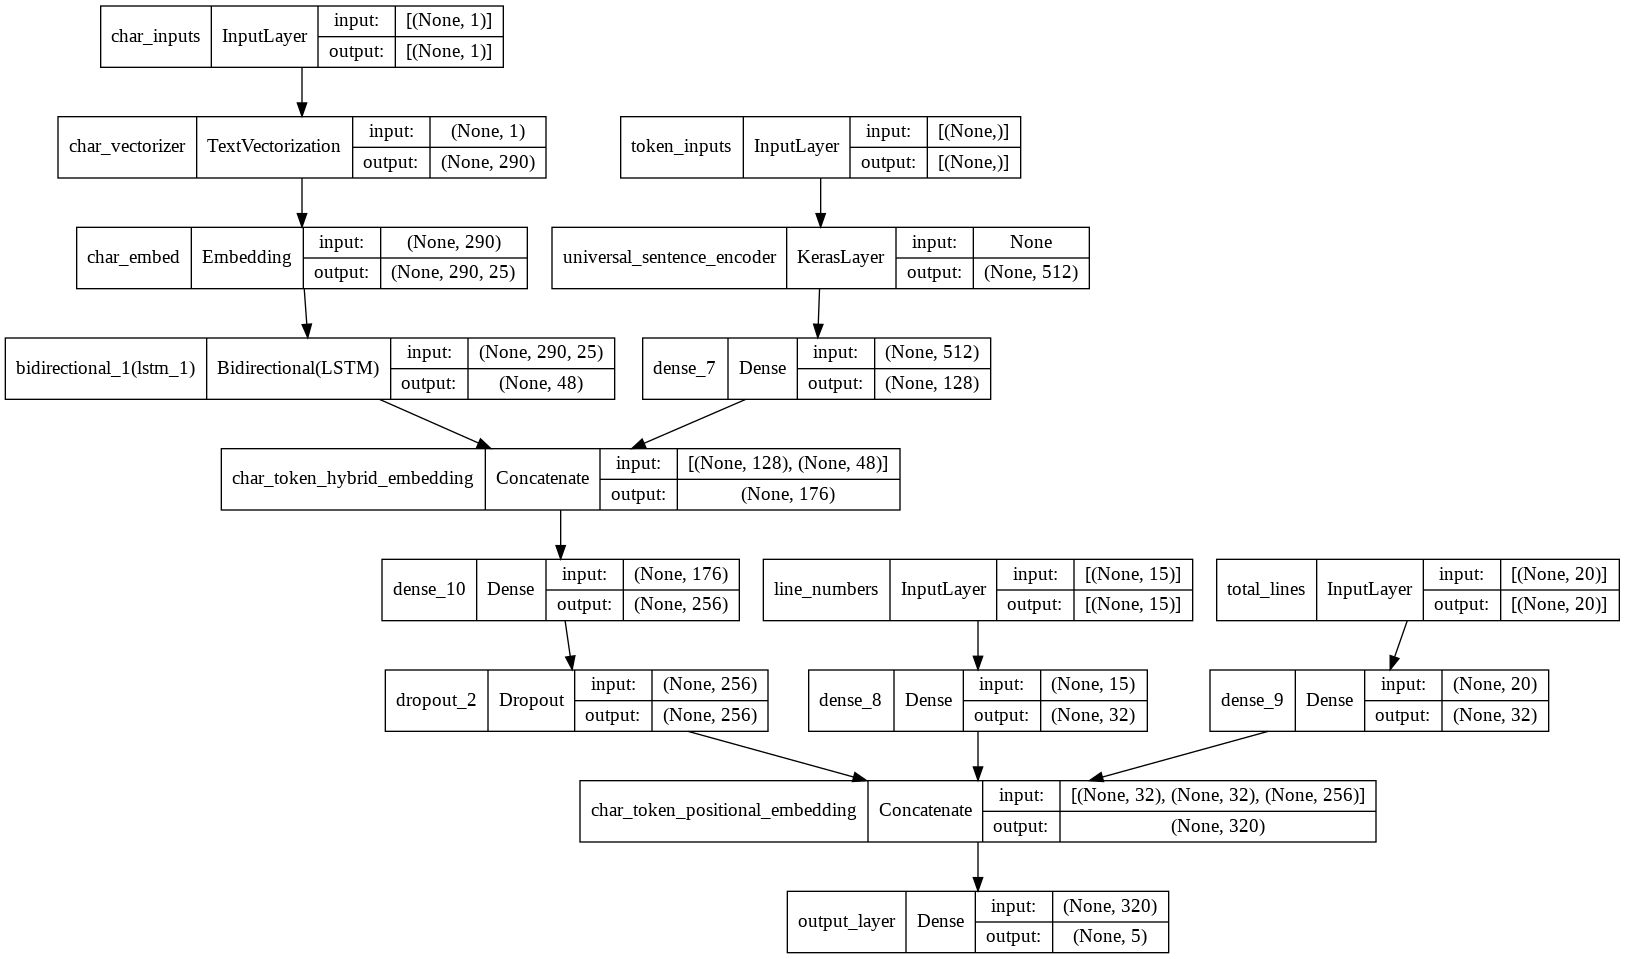

In [81]:
plot_model(model_5, show_shapes=True)

In [82]:
# Compile token, char and positional embedding model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [83]:
# Fit our tribrid embedding model
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1*len(train_char_token_pos_dataset)),
                              epochs=10,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1*len(val_char_token_pos_dataset)))

Epoch 1/10
562/562 [==============================] - 70s 117ms/step - loss: 1.0952 - accuracy: 0.7262 - val_loss: 0.9816 - val_accuracy: 0.8059
Epoch 2/10
562/562 [==============================] - 65s 115ms/step - loss: 0.9656 - accuracy: 0.8156 - val_loss: 0.9502 - val_accuracy: 0.8295
Epoch 3/10
562/562 [==============================] - 65s 115ms/step - loss: 0.9491 - accuracy: 0.8250 - val_loss: 0.9364 - val_accuracy: 0.8321
Epoch 4/10
562/562 [==============================] - 65s 115ms/step - loss: 0.9388 - accuracy: 0.8365 - val_loss: 0.9293 - val_accuracy: 0.8338
Epoch 5/10
562/562 [==============================] - 65s 115ms/step - loss: 0.9360 - accuracy: 0.8377 - val_loss: 0.9249 - val_accuracy: 0.8434
Epoch 6/10
562/562 [==============================] - 65s 115ms/step - loss: 0.9397 - accuracy: 0.8317 - val_loss: 0.9211 - val_accuracy: 0.8431
Epoch 7/10
562/562 [==============================] - 65s 115ms/step - loss: 0.9275 - accuracy: 0.8411 - val_loss: 0.9235 - val_ac

In [84]:
# Make predictions with the char token pos model
model_5_pred_probs = model_5.predict(test_char_token_pos_dataset, verbose=1)
model_5_pred_probs

# Convert pred probs to pred labels
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds

# Calculate results of char token pos model
model_5_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

942/942 [==============================] - 47s 49ms/step


{'accuracy': 84.49643271942924,
 'f1-score': 0.8420796064487105,
 'precision': 0.8453930388447831,
 'recall': 0.8449643271942924}

## Compare all the model results!

In [85]:
# Combine model results into a dataframe
all_models = pd.DataFrame({"model_0": baseline_results,
                           "model_1": model_1_results,
                           "model_2": model_2_results,
                           "model_3": model_3_results,
                           "model_4": model_4_results,
                           "model_5": model_5_results})
all_models = all_models.T

# Reduce the accuracy to same scale as other metrics
all_models["accuracy"] = all_models["accuracy"]/100

all_models

,accuracy,precision,recall,f1-score
model_0,0.716675,0.712432,0.716675,0.692510
model_1,0.806637,0.802027,0.806637,0.803125
model_2,0.708379,0.701231,0.708379,0.702444
model_3,0.743819,0.738261,0.743819,0.738849
model_4,0.755069,0.752835,0.755069,0.750928
model_5,0.844964,0.845393,0.844964,0.842080


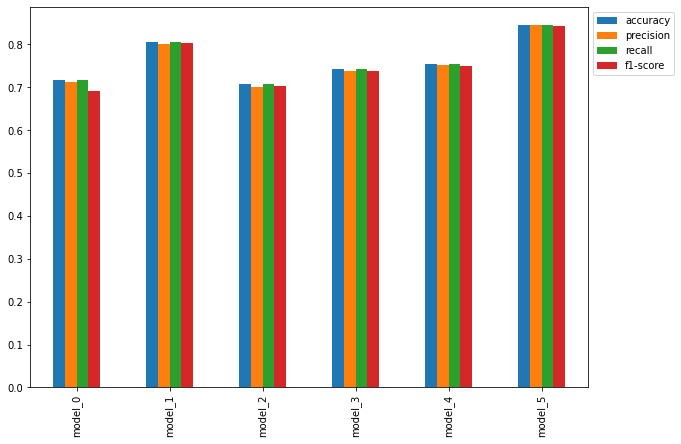

In [86]:
# Plot and compare all model results
all_models.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

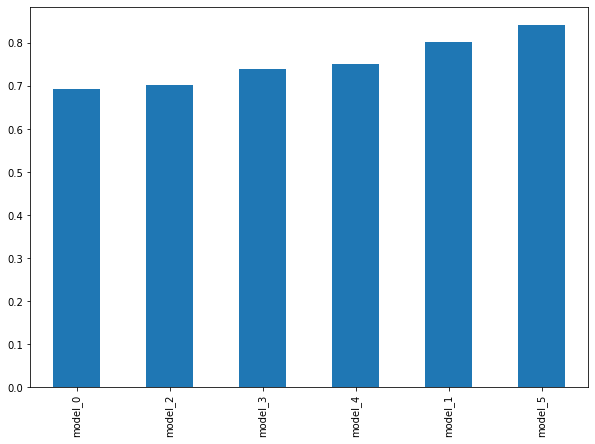

In [87]:
# Sort model results by f1-score
all_models.sort_values("f1-score", ascending=True)["f1-score"].plot(kind="bar", figsize=(10, 7));

## Saving the best model 

In [88]:
# Save the best performing model to SavedModel format (default)
model_5.save("best_model")

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


## Visualising the results (a sample of the test dataset)

In [89]:
class_names_lookup =  { i : class_names[i] for i in range(len(class_names))}
# class_names_lookup

targets = []
for i in model_5_preds.numpy().tolist():
  if i in class_names_lookup:
    targets.append(class_names_lookup[i])
test_df["predicted_target"] = targets
test_df[9:22]  # sample

,target,text,line_number,total_lines,predicted_target
9,BACKGROUND,minimally invasive endovascular aneurysm repai...,0,12,BACKGROUND
10,BACKGROUND,the aim of this study was to analyse the cost-...,1,12,OBJECTIVE
11,METHODS,resource use was determined from the amsterdam...,2,12,METHODS
12,METHODS,the analysis was performed from a provider per...,3,12,METHODS
13,METHODS,all costs were calculated as if all patients h...,4,12,METHODS
14,RESULTS,a total of @ patients were randomized .,5,12,RESULTS
15,RESULTS,the @-day mortality rate was @ per cent after ...,6,12,RESULTS
16,RESULTS,"at @months , the total mortality rate for evar...",7,12,RESULTS
17,RESULTS,the mean cost difference between evar and or w...,8,12,RESULTS
18,RESULTS,the incremental cost-effectiveness ratio per p...,9,12,RESULTS


In [90]:
final_string = ""
dictionary = {}
original_list = []

for ind in test_df.index:
  if test_df['line_number'][ind] != test_df['total_lines'][ind]:
    if test_df['predicted_target'][ind] not in dictionary:
      dictionary[test_df['predicted_target'][ind]] = test_df['text'][ind]
    else:
      final_string = (test_df['text'][ind])
      dictionary[test_df['predicted_target'][ind]] += final_string
  else:
    if test_df['predicted_target'][ind] not in dictionary:
      dictionary[test_df['predicted_target'][ind]] = test_df['text'][ind]
    else:
      final_string = (test_df['text'][ind])
      dictionary[test_df['predicted_target'][ind]] += final_string
      original_list.append(dictionary)
      dictionary = {}
original_list[1]

{'BACKGROUND': 'minimally invasive endovascular aneurysm repair ( evar ) could be a surgical technique that improves outcome of patients with ruptured abdominal aortic aneurysm ( raaa ) .',
 'CONCLUSIONS': 'nor was evar superior regarding cost-utility .evar may be more effective for raaa , but its increased costs mean that it is unaffordable based on current standards of societal willingness-to-pay for health gains .',
 'METHODS': 'resource use was determined from the amsterdam acute aneurysm ( ajax ) trial , a multicentre randomized trial comparing evar with or in patients with raaa .the analysis was performed from a provider perspective .all costs were calculated as if all patients had been treated in the same hospital ( onze lieve vrouwe gasthuis , teaching hospital ) .',
 'OBJECTIVE': 'the aim of this study was to analyse the cost-effectiveness and cost-utility of evar compared with standard open repair ( or ) in the treatment of raaa , with costs per @-day and @-month survivor as 

In [91]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [92]:
string = ""
for i in original_list[1]:
  var = color.BOLD + i + ':' + color.END
  print(var)
  print(original_list[1][i])
  print("\n")
  string += (var + " " + original_list[1][i] + "\n\n")

BACKGROUND:
minimally invasive endovascular aneurysm repair ( evar ) could be a surgical technique that improves outcome of patients with ruptured abdominal aortic aneurysm ( raaa ) .


OBJECTIVE:
the aim of this study was to analyse the cost-effectiveness and cost-utility of evar compared with standard open repair ( or ) in the treatment of raaa , with costs per @-day and @-month survivor as outcome parameters .


METHODS:
resource use was determined from the amsterdam acute aneurysm ( ajax ) trial , a multicentre randomized trial comparing evar with or in patients with raaa .the analysis was performed from a provider perspective .all costs were calculated as if all patients had been treated in the same hospital ( onze lieve vrouwe gasthuis , teaching hospital ) .


RESULTS:
a total of @ patients were randomized .the @-day mortality rate was @ per cent after evar and @ per cent for or : absolute risk reduction ( arr ) @ ( @ per cent confidence interval ( c.i. ) -@ to @ ) per cent .at 

# Predicting on unstructured PubMed RCT abstracts

In [93]:
!zip -r /content/best_model.zip /content/best_model

  adding: content/best_model/ (stored 0%)
  adding: content/best_model/keras_metadata.pb (deflated 91%)
  adding: content/best_model/variables/ (stored 0%)
  adding: content/best_model/variables/variables.index (deflated 77%)
  adding: content/best_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/best_model/saved_model.pb (deflated 72%)
  adding: content/best_model/assets/ (stored 0%)


In [94]:
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [95]:
def preprocess(data):
  """
  This function takes the content read from the file and performs nescessary preprocessing
  Arguments: data (content read from the file)
  Returns: preprocessed dataframe
  """
  # data
  text_list = sent_tokenize(data)
  data1 = data
  data1_list = sent_tokenize(data)  

  # Numbers are replaced with '@' 
  K = '@'
  for i in range(len(data1_list)):
    ele = data1_list[i]
    for e in ele:
      if e.isdigit():
        data1_list[i] = data1_list[i].replace(e, K)

  total_lines = [len(text_list) - 1 for i in range(len(text_list))]
  line_numbers = [i for i in range(len(text_list))]

  df = pd.DataFrame(list(zip(text_list, data1_list, line_numbers, total_lines)), columns =['unmodified_text', 'text', 'line_number', 'total_lines'])
  
  # Giving dummy label encoding for each of these sentences - to use tf.data.Datasets
  df["target"] = ""
  for i in df.index:
    j = i % 5
    df["target"][i] = class_names[j]

  return df, data1_list

# Make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

def predictions(dataset, class_names, model):
  """
  Takes the test dataset and returns the predicted labels
  Arguments: dataset (tf.data.datasets)
             class_names (different class labels)
             model 
  Returns: a list of predicted labels
  """
  # Make predictions with the char token pos model  
  pred_probs = model.predict(dataset, verbose=0)
  pred_probs

  # Convert pred probs to pred labels
  preds = tf.argmax(pred_probs, axis=1)
  preds

  class_names_lookup =  { i : class_names[i] for i in range(len(class_names))}
  #class_names_lookup

  targets = []
  for i in preds.numpy().tolist():
    if i in class_names_lookup:
      targets.append(class_names_lookup[i])
  return targets

def final_summary(df):
  """
  This function takes in the dataframe and displays the predicted output in a formatted manner.
  It also stores the structured abstract into a file.
  """
  final_string = ""
  dictionary = {}
  original_list = []

  for ind in df.index:
    if df['line_number'][ind] != df['total_lines'][ind]:
      if df['predicted_target'][ind] not in dictionary:
        dictionary[df['predicted_target'][ind]] = df['unmodified_text'][ind]
      else:
        final_string = (df['unmodified_text'][ind])
        dictionary[df['predicted_target'][ind]] += final_string
    else:
      if df['predicted_target'][ind] not in dictionary:
        dictionary[df['predicted_target'][ind]] = df['unmodified_text'][ind]
      else:
        final_string = (df['unmodified_text'][ind])
        dictionary[df['target'][ind]] += final_string
        original_list.append(dictionary)
        dictionary = {}
  #original_list[0]

  string = ""
  for i in original_list[0]:
    var = color.BOLD + i + ':' + color.END
    print(var)
    print(original_list[0][i])
    print("\n")
    string += (var + " " + original_list[0][i] + "\n\n")

  # Saving contents to a file
  text_file = open("structured_abstract.txt", "w")
  text_file.write(string)
  text_file.close()

In [96]:
def main():
  # Read in the abstract text file
  text_file = open("/content/Pubmed_RCT.txt", "r")
  data = text_file.read()  


  # Creating the dataset
  df, text_list = preprocess(data)

  chars = [split_chars(sentence) for sentence in df["text"].tolist()]
  labels_one_hot = one_hot_encoder.fit_transform(df["target"].to_numpy().reshape(-1, 1))
  total_lines_one_hot = tf.one_hot(df["total_lines"].to_numpy(), depth=20)
  line_numbers_one_hot = tf.one_hot(df["line_number"].to_numpy(), depth=15)
  char_token_pos_data = tf.data.Dataset.from_tensor_slices((line_numbers_one_hot,
                                                                total_lines_one_hot,
                                                                text_list,
                                                                chars))
  char_token_pos_labels = tf.data.Dataset.from_tensor_slices(labels_one_hot)
  char_token_pos_dataset = tf.data.Dataset.zip((char_token_pos_data, char_token_pos_labels))
  char_token_pos_dataset = char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

  targets = predictions(dataset=char_token_pos_dataset,
                        class_names=class_names,
                        model=model_5)
  df["predicted_target"] = targets
  final_summary(df)

In [97]:
main()

BACKGROUND:
Hepatitis C virus (HCV) and alcoholic liver disease (ALD), either alone or in combination, count for more than two thirds of all liver diseases in the Western world.There is no safe level of drinking in HCV-infected patients and the most effective goal for these patients is total abstinence.Baclofen, a GABA(B) receptor agonist, represents a promising pharmacotherapy for alcohol dependence (AD).The goal of this post-hoc analysis was to explore baclofen's effect in a subgroup of alcohol-dependent HCV-infected cirrhotic patients.


METHODS:
Previously, we performed a randomized clinical trial (RCT), which demonstrated the safety and efficacy of baclofen in patients affected by AD and cirrhosis.and 12 received placebo for 12-weeks.Baclofen may represent a clinically relevant alcohol pharmacotherapy for these patients.


RESULTS:
Any patient with HCV infection was selected for this analysis.Among the 84 subjects randomized in the main trial, 24 alcohol-dependent cirrhotic patien

**Note:** Above contents are stored in a file and can be downloaded

-----------------------------------------------------------------